### U-net with simple Resnet Blocks v3, StratifiedKFold 
* Make the validation data distribution more close to train and possibly final test data
* For demonstration only, can use with previous  version or other models to get higher score: 

  https://www.kaggle.com/shaojiaxin/u-net-with-simple-resnet-blocks
  
  https://www.kaggle.com/shaojiaxin/u-net-with-simple-resnet-blocks-v2-new-loss     
        


In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

import cv2
from sklearn.model_selection import StratifiedKFold

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
t_start = time.time()

/home/vishy/anaconda3/envs/tensorflowenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
cv_total = 5
#cv_index = 1 -5


version = 1
basic_name_ori = f'Unet_resnet_v{version}'
save_model_name = basic_name_ori + '.model'
submission_file = basic_name_ori +'6' + '.csv'

print(save_model_name)
print(submission_file)

Unet_resnet_v1.model
Unet_resnet_v1.csv


In [3]:
img_size_ori = 101
img_size_target = 101

def upsample(img):# not used
    return img
    
def downsample(img):# not used
    return img

In [4]:
path = '/home/vishy/Desktop/Kaggle/TGS/Data/'
subpath = '/home/vishy/Desktop/Kaggle/TGS/Submissions/'

In [5]:
# Loading of training/testing ids and depths
train_df = pd.read_csv(path+"train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv(path+"depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [6]:
train_df["images"] = [np.array(load_img(path+"train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [7]:
train_df["masks"] = [np.array(load_img(path+"train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

#### calculate mask type for stratify, the difficuly of training different mask type is different. 
* Reference  from Heng's discussion, search "error analysis" in the following link

https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63984#382657****

In [8]:
#### Reference  from Heng's discussion
# https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63984#382657
def get_mask_type(mask):
    border = 10
    outer = np.zeros((101-2*border, 101-2*border), np.float32)
    outer = cv2.copyMakeBorder(outer, border, border, border, border, borderType = cv2.BORDER_CONSTANT, value = 1)

    cover = (mask>0.5).sum()
    if cover < 8:
        return 0 # empty
    if cover == ((mask*outer) > 0.5).sum():
        return 1 #border
    if np.all(mask==mask[0]):
        return 2 #vertical

    percentage = cover/(101*101)
    if percentage < 0.15:
        return 3
    elif percentage < 0.25:
        return 4
    elif percentage < 0.50:
        return 5
    elif percentage < 0.75:
        return 6
    else:
        return 7

def histcoverage(coverage):
    histall = np.zeros((1,8))
    for c in coverage:
        histall[0,c] += 1
    return histall

train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_target, 2)

train_df["coverage_class"] = train_df.masks.map(get_mask_type)


In [9]:
train_all = []
evaluate_all = []
skf = StratifiedKFold(n_splits=cv_total, random_state=1234, shuffle=True)
for train_index, evaluate_index in skf.split(train_df.index.values, train_df.coverage_class):
    train_all.append(train_index)
    evaluate_all.append(evaluate_index)
    print(train_index.shape,evaluate_index.shape) # the shape is slightly different in different cv, it's OK

(3198,) (802,)
(3199,) (801,)
(3199,) (801,)
(3200,) (800,)
(3204,) (796,)


In [10]:
def get_cv_data(cv_index):
    train_index = train_all[cv_index-1]
    evaluate_index = evaluate_all[cv_index-1]
    x_train = np.array(train_df.images[train_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    y_train = np.array(train_df.masks[train_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    x_valid = np.array(train_df.images[evaluate_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    y_valid = np.array(train_df.masks[evaluate_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    return x_train,y_train,x_valid,y_valid

#### Show  some examples of different mask

(3198,) (802,)
train cv1, number of each mask class = 
 	[[1279.  192.   84.  372.  179.  407.  334.  351.]]
evaluate cv1, number of each mask class = 
 	 [[320.  48.  22.  93.  45. 102.  84.  88.]]


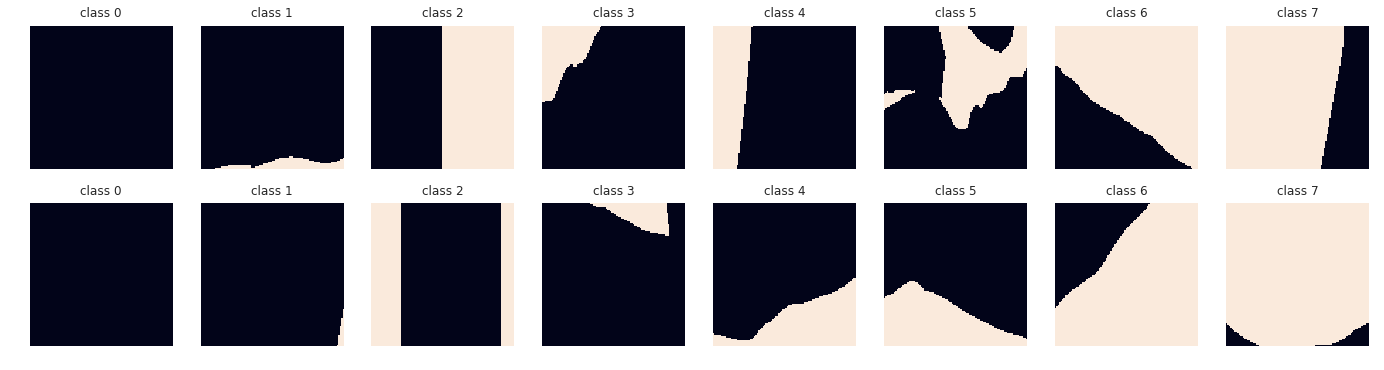

In [11]:
cv_index = 1
train_index = train_all[cv_index-1]
evaluate_index = evaluate_all[cv_index-1]

print(train_index.shape,evaluate_index.shape)
histall = histcoverage(train_df.coverage_class[train_index].values)
print(f'train cv{cv_index}, number of each mask class = \n \t{histall}')
histall_test = histcoverage(train_df.coverage_class[evaluate_index].values)
print(f'evaluate cv{cv_index}, number of each mask class = \n \t {histall_test}')

fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(24, 6), sharex=True, sharey=True)

# show mask class example
for c in range(8):
    j= 0
    for i in train_index:
        if train_df.coverage_class[i] == c:
            axes[j,c].imshow(np.array(train_df.masks[i])  )
            axes[j,c].set_axis_off()
            axes[j,c].set_title(f'class {c}')
            j += 1
            if(j>=2):
                break

In [12]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x


In [13]:
# Build model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [14]:
def get_iou_vector(A, B):
    A = np.squeeze(A) # new added 
    B = np.squeeze(B) # new added
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
            metric.append(0)
            continue
        if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
            metric.append(0)
            continue
        if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
            metric.append(1)
            continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0)  )/ (np.sum(union > 0) )
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [15]:
def build_complie_model(lr = 0.01):
    input_layer = Input((img_size_target, img_size_target, 1))
    output_layer = build_model(input_layer, 16,0.5)

    model1 = Model(input_layer, output_layer)

    c = optimizers.adam(lr = lr)
    model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])
    return model1

In [16]:
def plot_history(history,metric_name):
    fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_score.plot(history.epoch, history.history[metric_name], label="Train score")
    ax_score.plot(history.epoch, history.history["val_" + metric_name], label="Validation score")
    ax_score.legend()

def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

###########################################################################
 Unet_resnet_v1_cv1
Train on 6396 samples, validate on 802 samples
Epoch 1/100
 - 32s - loss: 0.4180 - my_iou_metric: 0.3925 - val_loss: 3.3321 - val_my_iou_metric: 0.3915

Epoch 00001: val_my_iou_metric improved from -inf to 0.39152, saving model to Unet_resnet_v1_cv1.model
Epoch 2/100
 - 22s - loss: 0.3366 - my_iou_metric: 0.5081 - val_loss: 0.3515 - val_my_iou_metric: 0.4890

Epoch 00002: val_my_iou_metric improved from 0.39152 to 0.48903, saving model to Unet_resnet_v1_cv1.model
Epoch 3/100
 - 22s - loss: 0.2962 - my_iou_metric: 0.5331 - val_loss: 0.8637 - val_my_iou_metric: 0.2241

Epoch 00003: val_my_iou_metric did not improve from 0.48903
Epoch 4/100
 - 22s - loss: 0.2614 - my_iou_metric: 0.5548 - val_loss: 0.6231 - val_my_iou_metric: 0.4201

Epoch 00004: val_my_iou_metric did not improve from 0.48903
Epoch 5/100
 - 23s - loss: 0.2399 - my_iou_metric: 0.5698 - val_loss: 1.0491 - val_my_iou_metric: 0.3804


Epoch 00044: val_my_iou_metric improved from 0.76534 to 0.77157, saving model to Unet_resnet_v1_cv1.model
Epoch 45/100
 - 23s - loss: 0.0747 - my_iou_metric: 0.7852 - val_loss: 0.1691 - val_my_iou_metric: 0.7641

Epoch 00045: val_my_iou_metric did not improve from 0.77157
Epoch 46/100
 - 23s - loss: 0.0754 - my_iou_metric: 0.7864 - val_loss: 0.1577 - val_my_iou_metric: 0.7692

Epoch 00046: val_my_iou_metric did not improve from 0.77157
Epoch 47/100
 - 24s - loss: 0.0736 - my_iou_metric: 0.7898 - val_loss: 0.1360 - val_my_iou_metric: 0.7749

Epoch 00047: val_my_iou_metric improved from 0.77157 to 0.77494, saving model to Unet_resnet_v1_cv1.model
Epoch 48/100
 - 23s - loss: 0.0752 - my_iou_metric: 0.7902 - val_loss: 0.1513 - val_my_iou_metric: 0.7818

Epoch 00048: val_my_iou_metric improved from 0.77494 to 0.78180, saving model to Unet_resnet_v1_cv1.model
Epoch 49/100
 - 23s - loss: 0.0735 - my_iou_metric: 0.7910 - val_loss: 0.1566 - val_my_iou_metric: 0.7762

Epoch 00049: val_my_iou_me

 - 23s - loss: 0.0568 - my_iou_metric: 0.8104 - val_loss: 0.1760 - val_my_iou_metric: 0.7847

Epoch 00090: val_my_iou_metric did not improve from 0.79202
Epoch 91/100
 - 23s - loss: 0.0561 - my_iou_metric: 0.8104 - val_loss: 0.1748 - val_my_iou_metric: 0.7850

Epoch 00091: val_my_iou_metric did not improve from 0.79202
Epoch 92/100
 - 23s - loss: 0.0563 - my_iou_metric: 0.8103 - val_loss: 0.1762 - val_my_iou_metric: 0.7833

Epoch 00092: val_my_iou_metric did not improve from 0.79202
Epoch 00092: early stopping
###########################################################################
 Unet_resnet_v1_cv2
Train on 6398 samples, validate on 801 samples
Epoch 1/100
 - 34s - loss: 0.4204 - my_iou_metric: 0.3657 - val_loss: 0.7059 - val_my_iou_metric: 0.3745

Epoch 00001: val_my_iou_metric improved from -inf to 0.37453, saving model to Unet_resnet_v1_cv2.model
Epoch 2/100
 - 22s - loss: 0.3334 - my_iou_metric: 0.5183 - val_loss: 0.5678 - val_my_iou_metric: 0.2237

Epoch 00002: val_my_iou_me

Epoch 42/100
 - 23s - loss: 0.0974 - my_iou_metric: 0.7645 - val_loss: 0.1412 - val_my_iou_metric: 0.7393

Epoch 00042: val_my_iou_metric did not improve from 0.76130
Epoch 43/100
 - 23s - loss: 0.0908 - my_iou_metric: 0.7668 - val_loss: 0.1305 - val_my_iou_metric: 0.7567

Epoch 00043: val_my_iou_metric did not improve from 0.76130
Epoch 44/100
 - 24s - loss: 0.0953 - my_iou_metric: 0.7699 - val_loss: 0.1259 - val_my_iou_metric: 0.7534

Epoch 00044: val_my_iou_metric did not improve from 0.76130
Epoch 45/100
 - 23s - loss: 0.0934 - my_iou_metric: 0.7612 - val_loss: 0.1206 - val_my_iou_metric: 0.7588

Epoch 00045: val_my_iou_metric did not improve from 0.76130
Epoch 46/100
 - 23s - loss: 0.0906 - my_iou_metric: 0.7677 - val_loss: 0.1205 - val_my_iou_metric: 0.7474

Epoch 00046: val_my_iou_metric did not improve from 0.76130

Epoch 00046: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
Epoch 47/100
 - 23s - loss: 0.0842 - my_iou_metric: 0.7789 - val_loss: 0.1222 - val_


Epoch 00087: val_my_iou_metric did not improve from 0.77378
Epoch 88/100
 - 23s - loss: 0.0677 - my_iou_metric: 0.7934 - val_loss: 0.1308 - val_my_iou_metric: 0.7675

Epoch 00088: val_my_iou_metric did not improve from 0.77378
Epoch 89/100
 - 24s - loss: 0.0665 - my_iou_metric: 0.7905 - val_loss: 0.1302 - val_my_iou_metric: 0.7697

Epoch 00089: val_my_iou_metric did not improve from 0.77378
Epoch 90/100
 - 23s - loss: 0.0671 - my_iou_metric: 0.7944 - val_loss: 0.1284 - val_my_iou_metric: 0.7695

Epoch 00090: val_my_iou_metric did not improve from 0.77378
Epoch 91/100
 - 23s - loss: 0.0675 - my_iou_metric: 0.7920 - val_loss: 0.1320 - val_my_iou_metric: 0.7647

Epoch 00091: val_my_iou_metric did not improve from 0.77378
Epoch 00091: early stopping
###########################################################################
 Unet_resnet_v1_cv3
Train on 6398 samples, validate on 801 samples
Epoch 1/100
 - 35s - loss: 0.4430 - my_iou_metric: 0.2979 - val_loss: 1.7530 - val_my_iou_metric: 0.

 - 23s - loss: 0.0865 - my_iou_metric: 0.7673 - val_loss: 0.1462 - val_my_iou_metric: 0.7574

Epoch 00041: val_my_iou_metric did not improve from 0.77564

Epoch 00041: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 42/100
 - 23s - loss: 0.0812 - my_iou_metric: 0.7773 - val_loss: 0.1406 - val_my_iou_metric: 0.7660

Epoch 00042: val_my_iou_metric did not improve from 0.77564
Epoch 43/100
 - 23s - loss: 0.0769 - my_iou_metric: 0.7838 - val_loss: 0.1465 - val_my_iou_metric: 0.7600

Epoch 00043: val_my_iou_metric did not improve from 0.77564
Epoch 44/100
 - 23s - loss: 0.0732 - my_iou_metric: 0.7846 - val_loss: 0.1454 - val_my_iou_metric: 0.7715

Epoch 00044: val_my_iou_metric did not improve from 0.77564
Epoch 45/100
 - 24s - loss: 0.0748 - my_iou_metric: 0.7833 - val_loss: 0.1559 - val_my_iou_metric: 0.7515

Epoch 00045: val_my_iou_metric did not improve from 0.77564
Epoch 46/100
 - 23s - loss: 0.0703 - my_iou_metric: 0.7869 - val_loss: 0.1606 - val_my_iou_metric


Epoch 00006: val_my_iou_metric did not improve from 0.59238
Epoch 7/100
 - 23s - loss: 0.2250 - my_iou_metric: 0.6010 - val_loss: 0.2037 - val_my_iou_metric: 0.6262

Epoch 00007: val_my_iou_metric improved from 0.59238 to 0.62625, saving model to Unet_resnet_v1_cv4.model
Epoch 8/100
 - 24s - loss: 0.2130 - my_iou_metric: 0.6223 - val_loss: 0.2409 - val_my_iou_metric: 0.6271

Epoch 00008: val_my_iou_metric improved from 0.62625 to 0.62712, saving model to Unet_resnet_v1_cv4.model
Epoch 9/100
 - 23s - loss: 0.1976 - my_iou_metric: 0.6353 - val_loss: 0.2202 - val_my_iou_metric: 0.6589

Epoch 00009: val_my_iou_metric improved from 0.62712 to 0.65887, saving model to Unet_resnet_v1_cv4.model
Epoch 10/100
 - 23s - loss: 0.1994 - my_iou_metric: 0.6410 - val_loss: 0.1846 - val_my_iou_metric: 0.6685

Epoch 00010: val_my_iou_metric improved from 0.65887 to 0.66850, saving model to Unet_resnet_v1_cv4.model
Epoch 11/100
 - 24s - loss: 0.1848 - my_iou_metric: 0.6626 - val_loss: 0.2382 - val_my_iou

 - 24s - loss: 0.0672 - my_iou_metric: 0.7885 - val_loss: 0.1668 - val_my_iou_metric: 0.7565

Epoch 00051: val_my_iou_metric did not improve from 0.76587
Epoch 52/100
 - 23s - loss: 0.0661 - my_iou_metric: 0.7921 - val_loss: 0.1671 - val_my_iou_metric: 0.7539

Epoch 00052: val_my_iou_metric did not improve from 0.76587
Epoch 53/100
 - 23s - loss: 0.0672 - my_iou_metric: 0.7881 - val_loss: 0.1696 - val_my_iou_metric: 0.7576

Epoch 00053: val_my_iou_metric did not improve from 0.76587
Epoch 54/100
 - 23s - loss: 0.0657 - my_iou_metric: 0.7898 - val_loss: 0.1645 - val_my_iou_metric: 0.7589

Epoch 00054: val_my_iou_metric did not improve from 0.76587
Epoch 55/100
 - 24s - loss: 0.0644 - my_iou_metric: 0.7943 - val_loss: 0.1659 - val_my_iou_metric: 0.7565

Epoch 00055: val_my_iou_metric did not improve from 0.76587

Epoch 00055: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
Epoch 56/100
 - 23s - loss: 0.0674 - my_iou_metric: 0.7957 - val_loss: 0.1668 - val_my_iou_metri

Epoch 3/100
 - 23s - loss: 0.2976 - my_iou_metric: 0.5433 - val_loss: 0.5115 - val_my_iou_metric: 0.4626

Epoch 00003: val_my_iou_metric improved from 0.37198 to 0.46256, saving model to Unet_resnet_v1_cv5.model
Epoch 4/100
 - 23s - loss: 0.2673 - my_iou_metric: 0.5661 - val_loss: 0.2686 - val_my_iou_metric: 0.5857

Epoch 00004: val_my_iou_metric improved from 0.46256 to 0.58568, saving model to Unet_resnet_v1_cv5.model
Epoch 5/100
 - 24s - loss: 0.2549 - my_iou_metric: 0.5676 - val_loss: 1.3519 - val_my_iou_metric: 0.1638

Epoch 00005: val_my_iou_metric did not improve from 0.58568
Epoch 6/100
 - 23s - loss: 0.2358 - my_iou_metric: 0.5854 - val_loss: 0.2120 - val_my_iou_metric: 0.5791

Epoch 00006: val_my_iou_metric did not improve from 0.58568
Epoch 7/100
 - 23s - loss: 0.2273 - my_iou_metric: 0.5896 - val_loss: 0.2296 - val_my_iou_metric: 0.6399

Epoch 00007: val_my_iou_metric improved from 0.58568 to 0.63995, saving model to Unet_resnet_v1_cv5.model
Epoch 8/100
 - 24s - loss: 0.219

 - 24s - loss: 0.0903 - my_iou_metric: 0.7637 - val_loss: 0.1430 - val_my_iou_metric: 0.7526

Epoch 00047: val_my_iou_metric did not improve from 0.77889
Epoch 48/100
 - 24s - loss: 0.0890 - my_iou_metric: 0.7647 - val_loss: 0.1290 - val_my_iou_metric: 0.7746

Epoch 00048: val_my_iou_metric did not improve from 0.77889
Epoch 49/100
 - 23s - loss: 0.0885 - my_iou_metric: 0.7655 - val_loss: 0.1315 - val_my_iou_metric: 0.7734

Epoch 00049: val_my_iou_metric did not improve from 0.77889

Epoch 00049: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
Epoch 50/100
 - 24s - loss: 0.0819 - my_iou_metric: 0.7720 - val_loss: 0.1173 - val_my_iou_metric: 0.7803

Epoch 00050: val_my_iou_metric improved from 0.77889 to 0.78028, saving model to Unet_resnet_v1_cv5.model
Epoch 51/100
 - 24s - loss: 0.0828 - my_iou_metric: 0.7728 - val_loss: 0.1277 - val_my_iou_metric: 0.7881

Epoch 00051: val_my_iou_metric improved from 0.78028 to 0.78807, saving model to Unet_resnet_v1_cv5.model
Epoch

 - 24s - loss: 0.0671 - my_iou_metric: 0.7893 - val_loss: 0.1404 - val_my_iou_metric: 0.7768

Epoch 00094: val_my_iou_metric did not improve from 0.78807
Epoch 95/100
 - 23s - loss: 0.0671 - my_iou_metric: 0.7877 - val_loss: 0.1399 - val_my_iou_metric: 0.7789

Epoch 00095: val_my_iou_metric did not improve from 0.78807
Epoch 96/100
 - 24s - loss: 0.0686 - my_iou_metric: 0.7885 - val_loss: 0.1361 - val_my_iou_metric: 0.7807

Epoch 00096: val_my_iou_metric did not improve from 0.78807
Epoch 97/100
 - 24s - loss: 0.0682 - my_iou_metric: 0.7832 - val_loss: 0.1404 - val_my_iou_metric: 0.7764

Epoch 00097: val_my_iou_metric did not improve from 0.78807
Epoch 98/100
 - 24s - loss: 0.0685 - my_iou_metric: 0.7835 - val_loss: 0.1376 - val_my_iou_metric: 0.7786

Epoch 00098: val_my_iou_metric did not improve from 0.78807
Epoch 99/100
 - 23s - loss: 0.0655 - my_iou_metric: 0.7887 - val_loss: 0.1387 - val_my_iou_metric: 0.7790

Epoch 00099: val_my_iou_metric did not improve from 0.78807
Epoch 100/1

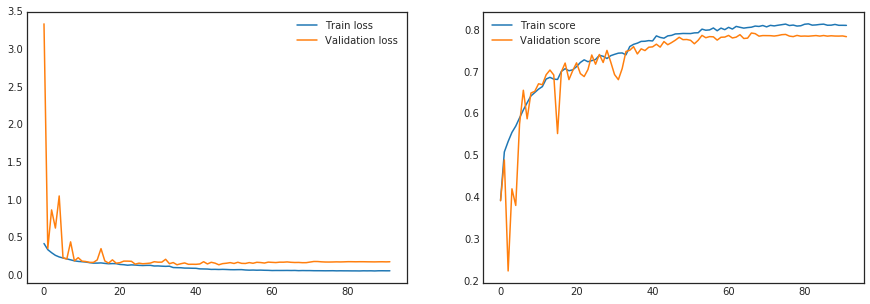

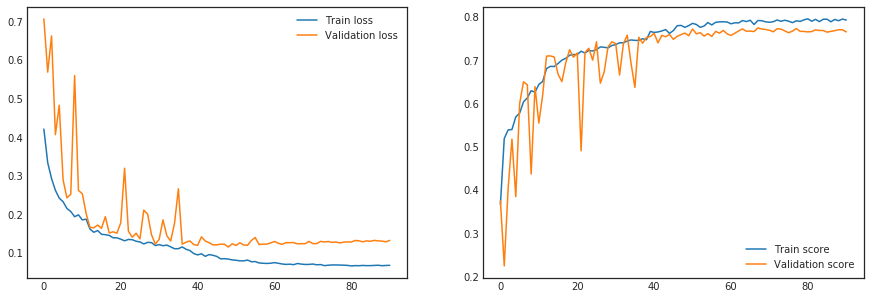

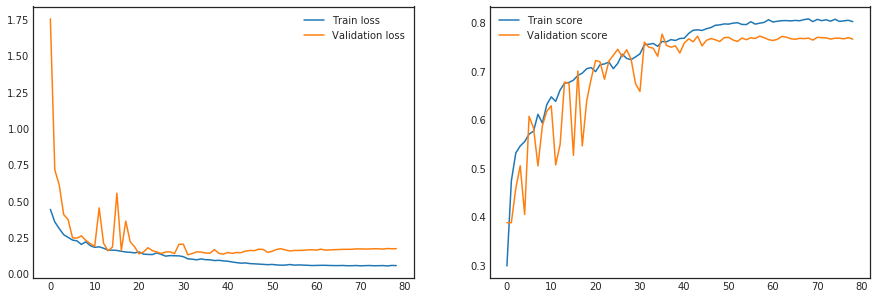

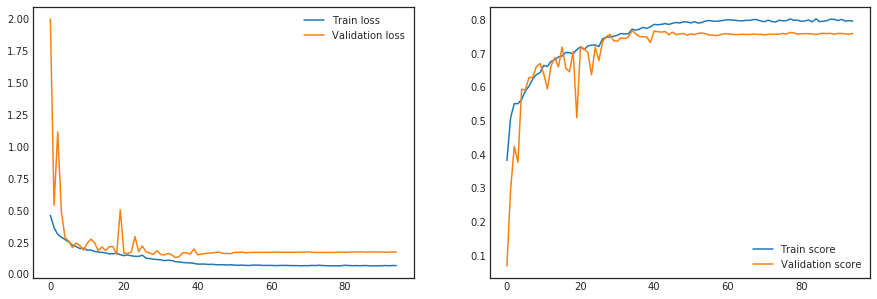

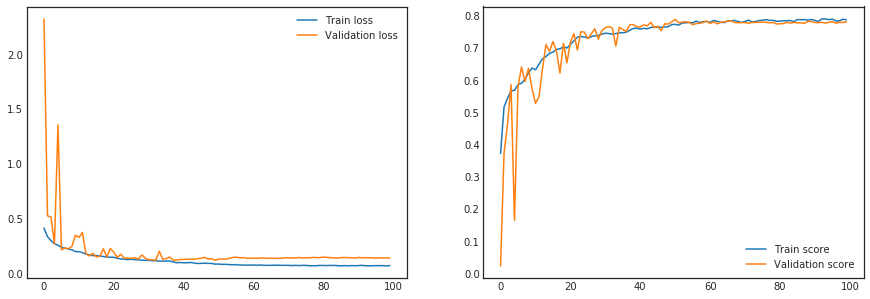

In [20]:
# training
ious = [0] * cv_total
for cv_index in range(cv_total):
    basic_name = f'Unet_resnet_v{version}_cv{cv_index+1}'
    print('###########################################################################\n', basic_name)
    save_model_name = basic_name + '.model'
    
    x_train, y_train, x_valid, y_valid =  get_cv_data(cv_index+1)
    
    #Data augmentation
    x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
    y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

    model = build_complie_model(lr = 0.01)
    early_stopping = EarlyStopping(monitor='my_iou_metric', mode = 'max',patience=10, verbose=1)
    model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',
                                  factor=0.5, patience=5, min_lr=0.0001, verbose=1)

    epochs = 100 #small number for demonstration 
    batch_size = 32
    history = model.fit(x_train, y_train,
                        validation_data=[x_valid, y_valid], 
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[model_checkpoint,reduce_lr,early_stopping], 
                        verbose=2)
    plot_history(history,'my_iou_metric')
    
    model.load_weights(save_model_name)
    
    preds_valid = predict_result(model,x_valid,img_size_target)
    ious[cv_index] = get_iou_vector(y_valid, (preds_valid > 0.5))
    
#model1.summary()

In [21]:
submission_file = basic_name_ori +'6' + '.csv'
print(submission_file)

Unet_resnet_v16.csv


In [22]:
for cv_index in range(cv_total):
    print(f"cv {cv_index} ious = {ious[cv_index]}")

cv 0 ious = 0.7945137157107233
cv 1 ious = 0.7800249687890137
cv 2 ious = 0.7745318352059924
cv 3 ious = 0.7655000000000001
cv 4 ious = 0.7869346733668341


In [23]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [25]:
x_test = np.array([(np.array(load_img(path+"test/images/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

In [26]:
# average the predictions from different folds
t1 = time.time()
preds_test = np.zeros(np.squeeze(x_test).shape)
for cv_index in range(cv_total):
    basic_name = f'Unet_resnet_v{version}_cv{cv_index+1}'
    model.load_weights(basic_name + '.model')
    preds_test += predict_result(model,x_test,img_size_target) /cv_total
    
t2 = time.time()
print(f"Usedtime = {t2-t1} s")

Usedtime = 228.35251712799072 s


In [27]:
t1 = time.time()
threshold  = 0.5 # some value in range 0.4- 0.5 may be better 
pred_dict = {idx: rle_encode(np.round(preds_test[i]) > threshold) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")


Usedtime = 1.3330552577972412 s


In [28]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(subpath+submission_file)

In [29]:
t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")

Kernel run time = 3.6145150276025135 hours
